In [1]:
import pandas as pd

import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt

from lib import ReplacementDataset, get_replacement_tokenizer

/home/bill/dev/replacement_language_modeling/env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("Tweets.csv")
text_samples = df["text"].tolist()
text_samples[:10]

['@VirginAmerica What @dhepburn said.',
 "@VirginAmerica plus you've added commercials to the experience... tacky.",
 "@VirginAmerica I didn't today... Must mean I need to take another trip!",
 '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
 "@VirginAmerica and it's a really big bad thing about it",
 "@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA",
 '@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)',
 '@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP',
 "@virginamerica Well, I didn't…but NOW I DO! :-D",
 "@VirginAmerica it was amazing, and arrived an hour early. You're too good to me."]

In [3]:
tokenizer = get_replacement_tokenizer("distilbert-base-uncased")
empty_id = tokenizer.convert_tokens_to_ids('[EMT]')

In [4]:
vocab_size = len(tokenizer)
dataset = ReplacementDataset(text_samples, tokenizer, empty_id)

In [5]:
def dummy_model(input_ids, attention_mask):
    # returns random logits
    batch_size, seq_len = input_ids.shape
    logits = torch.rand(batch_size, seq_len, vocab_size)
    return logits


In [6]:
input_ids, attention_mask, labels = dataset[0]
input_ids = input_ids.unsqueeze(0)
attention_mask = attention_mask.unsqueeze(0)
labels = labels.unsqueeze(0)
logits = dummy_model(input_ids, attention_mask)

In [7]:
print("Labels shape", labels.shape) # (batch_size, seq_len, vocab_size)
print("Logits shape", logits.shape) # (batch_size, seq_len, vocab_size)

Labels shape torch.Size([1, 19, 30523])
Logits shape torch.Size([1, 19, 30523])


In [8]:
loss_fn = torch.nn.CrossEntropyLoss()

In [9]:
loss_fn(labels.permute(0, 2, 1) * 1e3, labels.permute(0, 2, 1)).item()
# why is the loss not 0? 

-0.0

In [10]:
print((labels > 0).sum(-1))
print(labels.sum(dim=-1))
print((labels - labels).sum())

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1.]], dtype=torch.float64)
tensor(0., dtype=torch.float64)


In [11]:
loss = loss_fn(logits.permute(0, 2, 1), labels.permute(0, 2, 1))
print(logits.shape)
loss.shape

torch.Size([1, 19, 30523])


torch.Size([])

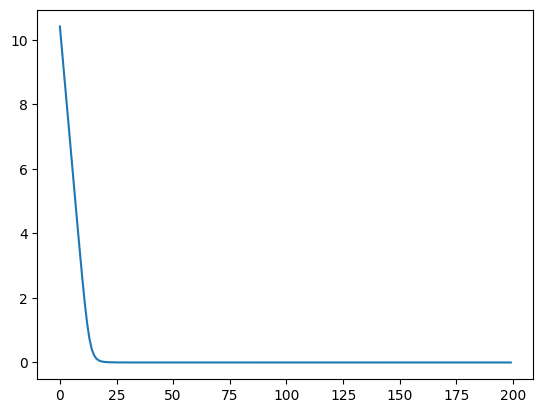

Final loss 6.17977418761783e-05


-0.0

In [12]:
# let's see what the logits converge to if we train them to minimize the loss
logit_copy = logits.clone().detach().requires_grad_(True)
optimizer = torch.optim.Adam([logit_copy], lr=0.4)
logit_copy.requires_grad = True
loss_history = []
for i in range(200):
    optimizer.zero_grad()
    loss = loss_fn(logit_copy.permute(0, 2, 1), labels.permute(0, 2, 1))
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())



plt.plot(loss_history)
plt.show()
print("Final loss", loss_history[-1])
loss_fn(labels.permute(0, 2, 1) * 1e3, labels.permute(0, 2, 1)).item()

In [14]:
# negative log loss between labels and labels
nll = -torch.log(labels.float() + 1e-8)
nll

tensor([[[18.4207, 18.4207, 18.4207,  ..., 18.4207, 18.4207, -0.0000],
         [18.4207, 18.4207, 18.4207,  ..., 18.4207, 18.4207, 18.4207],
         [18.4207, 18.4207, 18.4207,  ..., 18.4207, 18.4207, -0.0000],
         ...,
         [18.4207, 18.4207, 18.4207,  ..., 18.4207, 18.4207, -0.0000],
         [18.4207, 18.4207, 18.4207,  ..., 18.4207, 18.4207, 18.4207],
         [18.4207, 18.4207, 18.4207,  ..., 18.4207, 18.4207, -0.0000]]])